In [1]:
!pip install tensorflow==2.19.0

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib

In [5]:
image_dir = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/images/images"
label_file = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/annotations/annotations/list.txt"
model_path = "C:/Users/HP/Desktop/ML_DS/CNN/notebooks/model/best_model.h5"

with open(label_file, 'r') as f:
    lines = f.readlines()[6:] 

data = []
for line in lines:
    parts = line.strip().split()
    if len(parts) >= 2:
        filename = parts[0] + ".jpg"
        label = "_".join(parts[0].split("_")[:-1])
        full_path = os.path.join(image_dir, filename)
        if os.path.exists(full_path):
            data.append((full_path, label))

model = load_model(model_path)


In [6]:
label_names = sorted(set(label for _, label in data))
label2idx = {label: idx for idx, label in enumerate(label_names)}
data = [(img, label2idx[label]) for img, label in data]

train_val_data, test_data = train_test_split(data, test_size=0.15, stratify=[label for _, label in data], random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.15, stratify=[label for _, label in train_val_data], random_state=42)

def build_dataset(data_list):
    paths, labels = zip(*data_list)
    ds = tf.data.Dataset.from_tensor_slices((list(paths), list(labels)))

    def load_and_preprocess(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (224, 224))
        image = preprocess_input(image)
        return image, label

    return ds.map(load_and_preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = build_dataset(train_data)
val_ds = build_dataset(val_data)
test_ds = build_dataset(test_data)

In [10]:
def evaluate_model(model, test_ds):
    loss, acc = model.evaluate(test_ds)
    print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")
    return acc

evaluate_model(model, test_ds)

35/35 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9527 - loss: 0.1581
Test Accuracy: 0.9438, Test Loss: 0.1627


0.9437896609306335

In [11]:
y_true = [label for _, label in test_data]
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


35/35 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


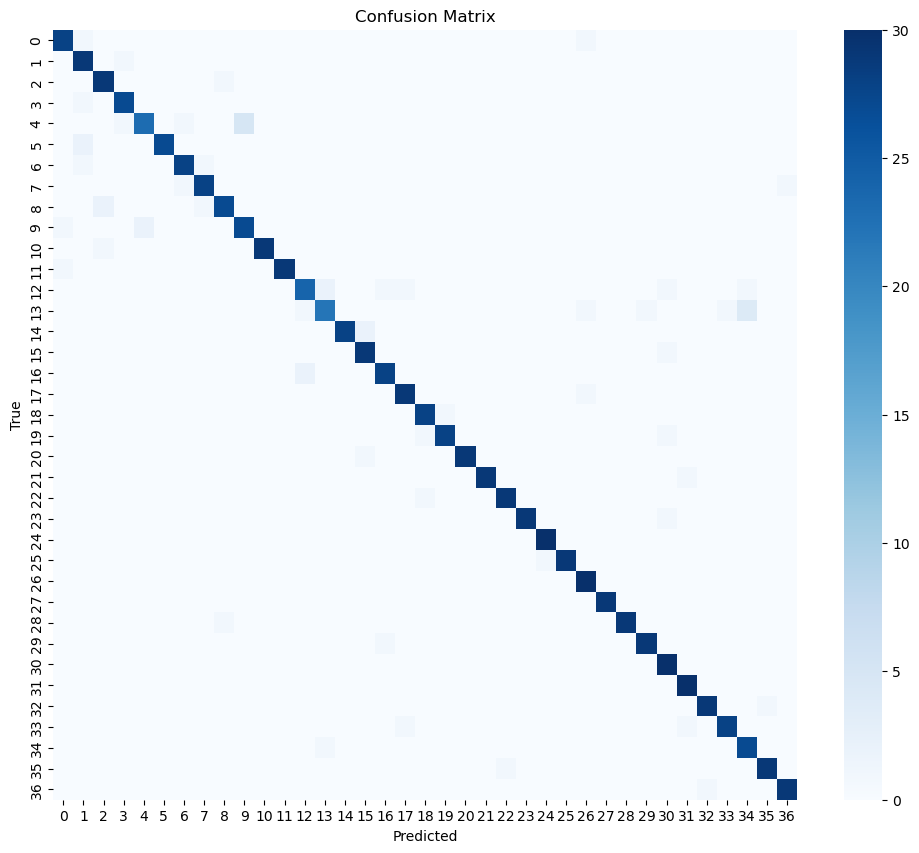

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
plt.show()

In [16]:
confidences = np.max(y_pred_probs, axis=1)
incorrect_indices = np.where(y_pred != y_true)[0]
misclassified_conf = [(i, confidences[i]) for i in incorrect_indices]

missclassified_dir = "C:/Users/HP/Desktop/ML_DS/CNN/src/misclassified"
os.makedirs(missclassified_dir, exist_ok=True)
for i in incorrect_indices:
    img_path = test_data[i][0]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img.save(os.path.join(missclassified_dir, f"misclassified_{i}_conf_{confidences[i]:.2f}.jpg"))
    

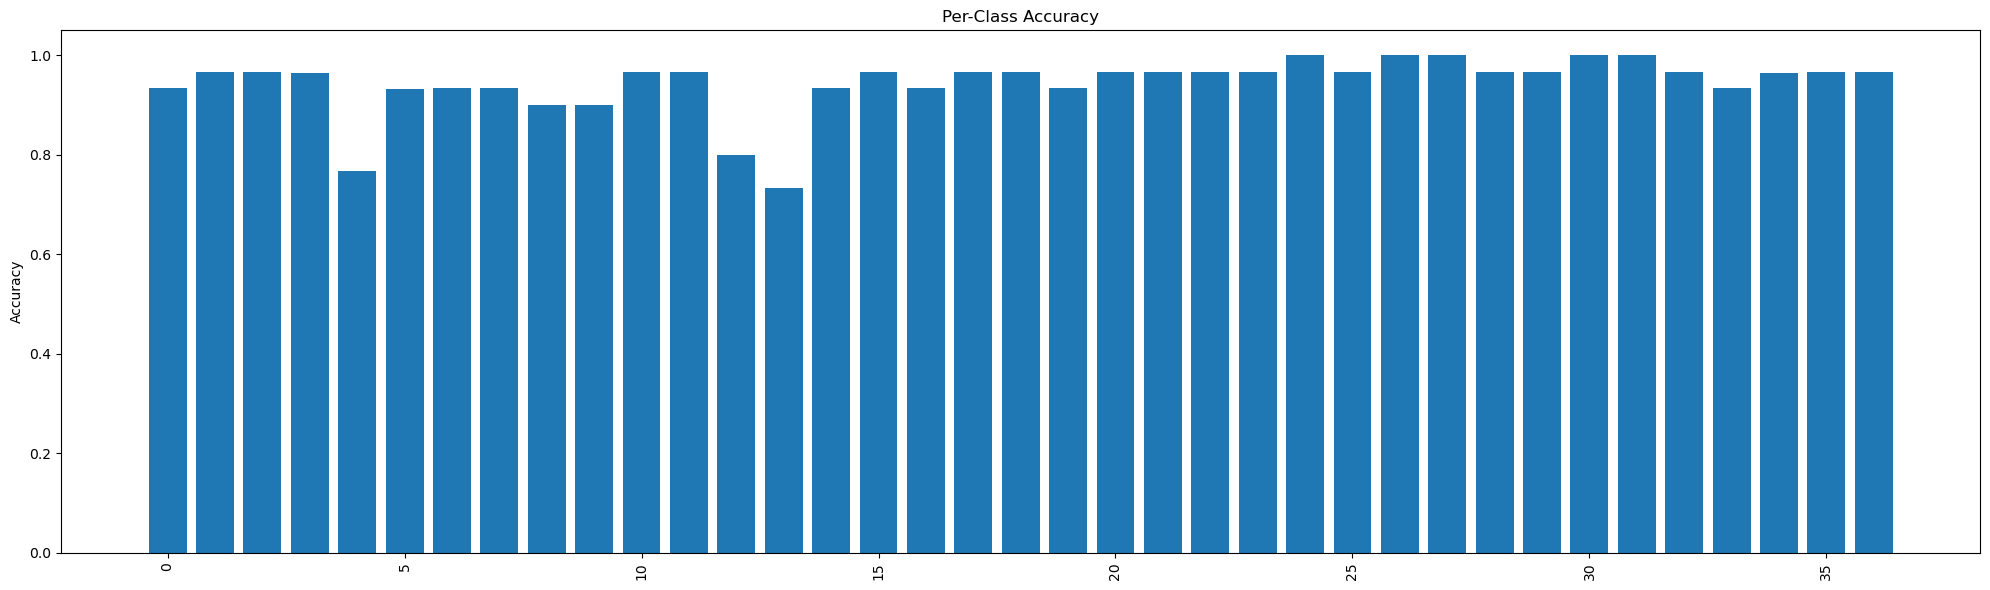

In [ ]:
from collections import Counter, defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for true,pred in zip(y_true, y_pred):
    total_per_class[true] += 1
    if true == pred:
        correct_per_class[true] += 1

per_class_accuracy = {label: correct_per_class[label] / total_per_class[label] for label in total_per_class}

plt.figure(figsize=(20, 6))
plt.bar(per_class_accuracy.keys(), per_class_accuracy.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.show()
